In [5]:
import numpy as np

# Parameters for the option and market
S0 = 100  # Initial stock price
K = 100  # Strike price
T = 1.0  # Time to maturity in years
r = 0.05  # Risk-free rate
sigma = 0.2  # Volatility of the underlying asset

# Simulation parameters
num_simulations = 100  # Number of simulated asset paths
num_steps = 252  # Number of steps in the time horizon

# Time step
dt = T / num_steps

# Simulate asset paths and hedging
portfolio_values = np.zeros(num_simulations)
for simulation in range(num_simulations):
    S = np.zeros(num_steps)
    S[0] = S0
    hedge = np.zeros(num_steps)
    option_value = np.zeros(num_steps)
    
    # Set up the hedge at time zero
    option_price, delta = black_scholes(S0, K, T, r, sigma)
    option_value[0] = option_price
    hedge[0] = delta * S0
    
    for step in range(1, num_steps):
        
        # Simulate the stock price path
        z = np.random.standard_normal()
        S[step] = S[step-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z)
        
        # Re-hedge at each step based on the new stock price
        option_price, delta = black_scholes(S[step], K, T - dt * step, r, sigma)
        option_value[step] = option_price
        hedge[step] = delta * S[step]
        
        # Assume that the cash from unhedging is invested at the risk-free rate
        cash = np.exp(r * dt) * (hedge[step-1] - delta * S[step-1])
        hedge[step] += cash
    
    # Final portfolio value is the option payoff minus the cost of the hedge
    option_payoff = max(S[-1] - K, 0)
    portfolio_values[simulation] = option_payoff - hedge[-1]

# Display the results
print(f"Mean final portfolio value: {np.mean(portfolio_values)}")
print(f"Standard deviation of final portfolio value: {np.std(portfolio_values)}")



Mean final portfolio value: -63.75397087739453
Standard deviation of final portfolio value: 2.772626184992009


In [23]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

# Set up parameters
S0 = 100  # Initial stock price
K = 100  # Strike price
T = 1.0  # Time to maturity
r = 0.05  # Risk-free rate
sigma = 0.2  # Volatility
M = 50  # Number of time steps
dt = T / M  # Time step size
I = 10000  # Number of simulation paths

# Function to simulate stock price paths
def simulate_stock_paths(S0, r, sigma, T, M, I):
    paths = np.zeros((M + 1, I))
    paths[0] = S0
    for t in range(1, M + 1):
        Z = np.random.standard_normal(I)
        paths[t] = paths[t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z)
    return paths

# Function to calculate the delta of an option
def calculate_delta(S, K, r, sigma, T, t):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * (T - t)) / (sigma * np.sqrt(T - t))
    return norm.cdf(d1)

# Simulate stock price paths
paths = simulate_stock_paths(S0, r, sigma, T, M, I)

# Initialize arrays for VaR and ES
VaR = np.zeros(I)
ES = np.zeros(I)

# Process each path independently
for i in range(I):
    portfolio_value = np.zeros(M + 1)
    cash = np.zeros(M + 1)
    stock_position = np.zeros(M + 1)
    delta = calculate_delta(S0, K, r, sigma, T, 0)
    stock_position[0] = delta * S0
    cash[0] = -delta * S0
    for t in range(1, M + 1):
        delta = calculate_delta(paths[t, i], K, r, sigma, T, t * dt)
        stock_position[t] = delta * paths[t, i]
        cash[t] = cash[t - 1] * np.exp(r * dt) + (stock_position[t - 1] - stock_position[t])
        portfolio_value[t] = stock_position[t] + cash[t]
    PnL = portfolio_value - portfolio_value[0]
    VaR[i] = np.percentile(PnL, 5)
    ES[i] = np.mean(PnL[PnL <= VaR[i]])

# Average VaR and ES across all paths
average_VaR = np.mean(VaR)
average_ES = np.mean(ES)

# Plotting


print(f"Average 95% VaR: {average_VaR}")
print(f"Average 95% ES: {average_ES}")



/var/folders/c3/j8w7q93153v6x8_vm3r3czv00000gn/T/ipykernel_34203/2656732584.py:26: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * (T - t)) / (sigma * np.sqrt(T - t))


Average 95% VaR: -3.1778790493358122
Average 95% ES: -3.2827076693606965


In [32]:
import numpy as np
from scipy.stats import norm

def calculate_delta(S, K, r, sigma, T, t):
    """
    Calculate the delta of an option using the Black-Scholes formula.
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * (T - t)) / (sigma * np.sqrt(T - t))
    return norm.cdf(d1)

def calculate_var_es(portfolio_values, confidence_level=0.95):
    """
    Calculate VaR and ES for a series of portfolio values.
    """
    sorted_returns = np.sort(portfolio_values)
    var_index = int((1 - confidence_level) * len(sorted_returns))
    VaR = sorted_returns[var_index]
    ES = sorted_returns[:var_index].mean()
    return VaR, ES

# Parameters
S0 = 100  # Initial stock price
K = 100  # Strike price
T = 1.0  # Time to maturity
r = 0.05  # Risk-free rate
sigma = 0.2  # Volatility
M = 50  # Number of time steps
dt = T / M  # Time step size
I = 1000  # Number of simulation paths

# Simulate paths
paths_brownian = simulate_brownian_motion_paths(S0, r, sigma, T, M, I)
paths_student_t = simulate_student_t_paths(S0, r, sigma, T, M, I, v=4)

# Initialize arrays for P&L
PnL_brownian = np.zeros(I)
PnL_student_t = np.zeros(I)

# Process each path independently
for i in range(I):
    for paths, PnL in [(paths_brownian, PnL_brownian), (paths_student_t, PnL_student_t)]:
        portfolio_value = np.zeros(M + 1)
        cash = np.zeros(M + 1)
        stock_position = np.zeros(M + 1)
        delta = calculate_delta(S0, K, r, sigma, T, 0)
        stock_position[0] = delta * S0
        cash[0] = -delta * S0
        for t in range(1, M + 1):
            delta = calculate_delta(paths[t, i], K, r, sigma, T, t * dt)
            stock_position[t] = delta * paths[t, i]
            cash[t] = cash[t - 1] * np.exp(r * dt) + (stock_position[t - 1] - stock_position[t])
            portfolio_value[t] = stock_position[t] + cash[t]
        PnL[i] = portfolio_value[-1] - portfolio_value[0]

# Calculate VaR and ES for each set of paths
VaR_brownian, ES_brownian = calculate_var_es(PnL_brownian)
VaR_student_t, ES_student_t = calculate_var_es(PnL_student_t)

print("Brownian Motion Paths: VaR =", VaR_brownian, ", ES =", ES_brownian)
print("Student-t Paths: VaR =", VaR_student_t, ", ES =", ES_student_t)


/var/folders/c3/j8w7q93153v6x8_vm3r3czv00000gn/T/ipykernel_34203/276700664.py:8: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * (T - t)) / (sigma * np.sqrt(T - t))


Brownian Motion Paths: VaR = -5.710046735645335 , ES = -6.126016907220602
Student-t Paths: VaR = -6.3770284179823875 , ES = -6.941241912594778


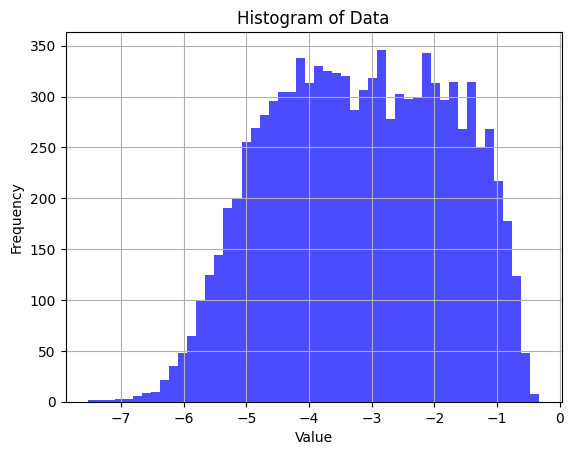

In [24]:
plt.hist(VaR, bins=50, color='blue', alpha=0.7)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Data')
plt.grid(True)

# Display the histogram
plt.show()

In [33]:
import numpy as np
import scipy.stats
#from scipy.stats import t as tdi

def simulate_brownian_motion_paths(S0, r, sigma, T, M, I):
    """
    Simulate stock price paths using geometric Brownian motion.

    :param S0: Initial stock price
    :param r: Risk-free rate
    :param sigma: Volatility of the underlying asset
    :param T: Time to maturity
    :param M: Number of time steps
    :param I: Number of simulation paths
    :return: Simulated paths array
    """
    dt = T / M  # Time step size
    paths = np.zeros((M + 1, I))
    paths[0] = S0
    for t in range(1, M + 1):
        Z = np.random.standard_normal(I)  # Random variables from the normal distribution
        paths[t] = paths[t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z)
    return paths

def simulate_student_t_paths(S0, r, sigma, T, M, I, v):
    """
    Simulate stock price paths using a process with increments distributed according to a Student-t distribution.

    :param S0: Initial stock price
    :param r: Risk-free rate
    :param sigma: Volatility of the underlying asset
    :param T: Time to maturity
    :param M: Number of time steps
    :param I: Number of simulation paths
    :param v: Degrees of freedom for the Student-t distribution
    :return: Simulated paths array
    """
    dt = T / M  # Time step size
    paths = np.zeros((M + 1, I))
    paths[0] = S0
    for t in range(1, M + 1):
        Z = scipy.stats.t.rvs(df=v, size=I)  # Random variables from the Student-t distribution
        paths[t] = paths[t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z)
    return paths

# Example usage of the functions
S0 = 100  # Initial stock price
r = 0.05  # Risk-free rate
sigma = 0.2  # Volatility
T = 1.0  # Time to maturity
M = 50  # Number of time steps
I = 1000  # Number of simulation paths
v = 4  # Degrees of freedom for the Student-t distribution

# Simulate paths using Brownian motion and Student-t process
brownian_motion_paths = simulate_brownian_motion_paths(S0, r, sigma, T, M, I)
student_t_paths = simulate_student_t_paths(S0, r, sigma, T, M, I, v)

# 'brownian_motion_paths' and 'student_t_paths' are now arrays containing the simulated paths
# using geometric Brownian motion and Student-t process, respectively.


In [34]:
import numpy as np
from scipy.stats import norm, t


# Black-Scholes option price and delta
def black_scholes(S, K, T, r, sigma, option_type='call'):
    """Calculate Black-Scholes option price and delta."""
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option_type == 'call':
        option_price = S * si.norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
        delta = norm.cdf(d1)
    else:
        option_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
        delta = -norm.cdf(-d1)
    
    return option_price, delta


def simulate_brownian_motion_paths(S0, r, sigma, T, M, I):
    """
    Simulate stock price paths using geometric Brownian motion.
    """
    dt = T / M
    paths = np.zeros((M + 1, I))
    paths[0] = S0
    for t in range(1, M + 1):
        Z = np.random.standard_normal(I)
        paths[t] = paths[t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z)
    return paths

def simulate_student_t_paths(S0, r, sigma, T, M, I, v):
    """
    Simulate stock price paths with increments distributed according to a Student-t distribution.
    """
    dt = T / M
    paths = np.zeros((M + 1, I))
    paths[0] = S0
    for i in range(1, M + 1):
        Z = t.rvs(df=v, size=I)
        paths[i] = paths[i - 1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z)
    return paths

def calculate_delta(S, K, r, sigma, T, t):
    """
    Calculate the delta of an option using the Black-Scholes formula.
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * (T - t)) / (sigma * np.sqrt(T - t))
    return norm.cdf(d1)

def calculate_var_es(portfolio_values, confidence_level=0.95):
    """
    Calculate VaR and ES for a series of portfolio values.
    """
    sorted_returns = np.sort(portfolio_values)
    var_index = int((1 - confidence_level) * len(sorted_returns))
    VaR = sorted_returns[var_index]
    ES = sorted_returns[:var_index].mean()
    return VaR, ES

# Parameters
S0 = 100  # Initial stock price
K = 100  # Strike price
T = 1.0  # Time to maturity
r = 0.05  # Risk-free rate
sigma = 0.2  # Volatility
M = 50  # Number of time steps
dt = T / M  # Time step size
I = 1000  # Number of simulation paths
v = 4  # Degrees of freedom for the Student-t distribution

# Simulate paths
paths_brownian = simulate_brownian_motion_paths(S0, r, sigma, T, M, I)
paths_student_t = simulate_student_t_paths(S0, r, sigma, T, M, I, v)

# Initialize arrays for P&L
PnL_brownian = np.zeros(I)
PnL_student_t = np.zeros(I)

# Process each path independently
for i in range(I):
    for paths, PnL in [(paths_brownian, PnL_brownian), (paths_student_t, PnL_student_t)]:
        portfolio_value = np.zeros(M + 1)
        cash = np.zeros(M + 1)
        stock_position = np.zeros(M + 1)
        delta = calculate_delta(S0, K, r, sigma, T, 0)
        stock_position[0] = delta * S0
        cash[0] = -delta * S0
        for t in range(1, M + 1):
            delta = calculate_delta(paths[t, i], K, r, sigma, T, t * dt)
            stock_position[t] = delta * paths[t, i]
            cash[t] = cash[t - 1] * np.exp(r * dt) + (stock_position[t - 1] - stock_position[t])
            portfolio_value[t] = stock_position[t] + cash[t]
        PnL[i] = portfolio_value[-1] - portfolio_value[0]

# Calculate VaR and ES for each set of paths
VaR_brownian, ES_brownian = calculate_var_es(PnL_brownian)
VaR_student_t, ES_student_t = calculate_var_es(PnL_student_t)

print("Brownian Motion Paths: VaR =", VaR_brownian, ", ES =", ES_brownian)
print("Student-t Paths: VaR =", VaR_student_t, ", ES =", ES_student_t)


/var/folders/c3/j8w7q93153v6x8_vm3r3czv00000gn/T/ipykernel_34203/1245878848.py:49: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * (T - t)) / (sigma * np.sqrt(T - t))


Brownian Motion Paths: VaR = -5.800622097153081 , ES = -6.195284365454309
Student-t Paths: VaR = -6.498306382678038 , ES = -7.084404339756437


1000